In [1]:
import pandas as pd

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from shapely.geometry import Point

import math

<Axes: >

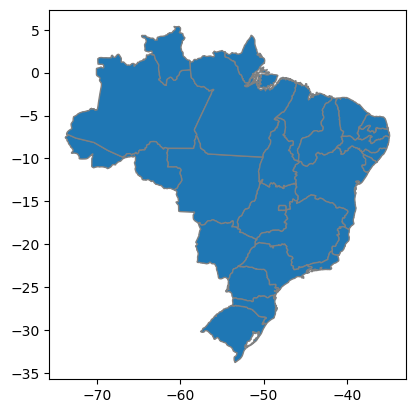

In [2]:
brasil = gpd.read_file("GeoJson/data/Brasil.json")
brasil.plot(edgecolor = "gray")

In [3]:
def read_csv(file):
    return pd.read_csv(f"DataSet2/{file}.csv", dtype={'zip_code': str})
    
geo = read_csv("geo")
customers = read_csv("customers")
sellers = read_csv("sellers")



In [4]:
def draw_map(gdf, col, title, label):
    ax = gdf.plot(column = col, cmap = 'YlOrRd', edgecolor= 'grey', legend = True, figsize=(14, 8))

    texts = []
    for x, y, label in zip(gdf.center.x, gdf.center.y, gdf[label]):
        t = ax.text(x, y, label, fontsize=8) # Use ax.text for adjustText compatibility
        texts.append(t)
        
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.xticks(rotation = 'vertical')
    plt.title(title)
    plt.show();

## Customer

### Total Customer Map

In [5]:
customers.head()

,customer_id,customer_unique_id,zip_code,city,state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
cs = customers.groupby('state')['customer_unique_id'].nunique().reset_index()
cs.columns = ['UF', 'total_customer']
cs.head()

,UF,total_customer
0,AC,77
1,AL,401
2,AM,143
3,AP,67
4,BA,3277


In [7]:
gdf = pd.merge(brasil[["UF", "geometry"]], cs, on='UF', how='inner')

# Create a copy of the geometry using EPSG:3857 
geometry_3857 = gdf.geometry.to_crs(epsg = 3857)

# Find the center point for Markers/PopUps
gdf['center'] = geometry_3857.centroid.to_crs(epsg = 4236)

gdf.head()

,UF,geometry,total_customer,center
0,AC,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",77,POINT (-70.44565 -9.33281)
1,AL,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",401,POINT (-36.61065 -9.50338)
2,AP,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",67,POINT (-51.9383 1.44925)
3,AM,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",143,POINT (-64.66208 -4.2071)
4,BA,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",3277,POINT (-41.66166 -12.49308)


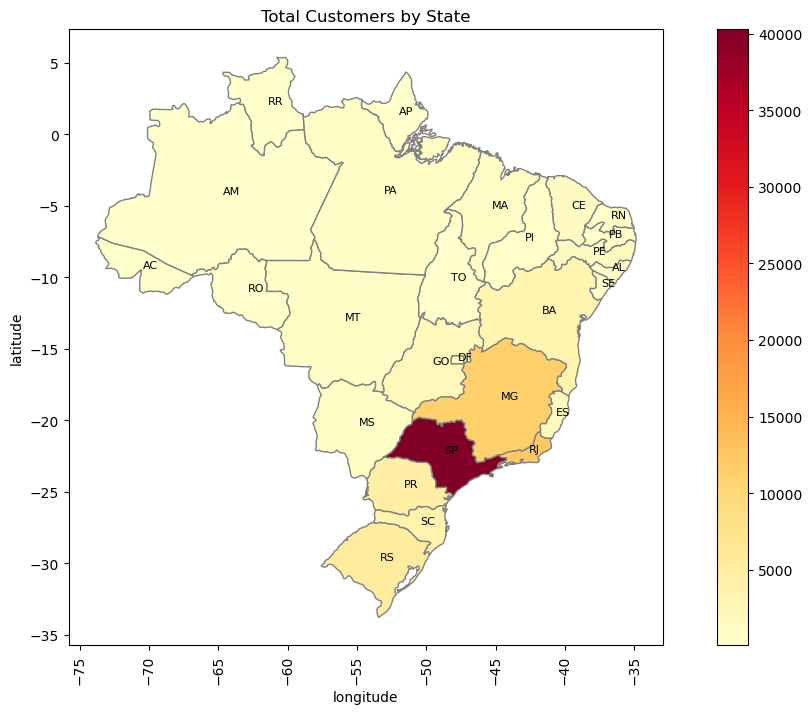

In [8]:
draw_map(gdf, 'total_customer', 'Total Customers by State', 'UF')


### Customer Density by Region (Population)

In [9]:
census_states = pd.read_csv("DataSet2/population_states_2022.csv")
census_states.head()

,population,state_id,state_name
0,830018,AC,Acre
1,3127683,AL,Alagoas
2,733759,AP,Amapá
3,3941613,AM,Amazonas
4,14141626,BA,Bahia


In [10]:
density = pd.merge(gdf, census_states,  left_on = "UF", right_on = "state_id", how="left")
density.isnull().sum()

UF                0
geometry          0
total_customer    0
center            0
population        0
state_id          0
state_name        0
dtype: int64

In [11]:
#Number of unique customers per 10,000 residents in a specific area.
def get_density(row):
    per_residents = 100
    div = (row['total_customer'] / row['population']) * per_residents
    return div
gdf['density'] =  density.apply(lambda row: get_density(row) , axis = 1) 

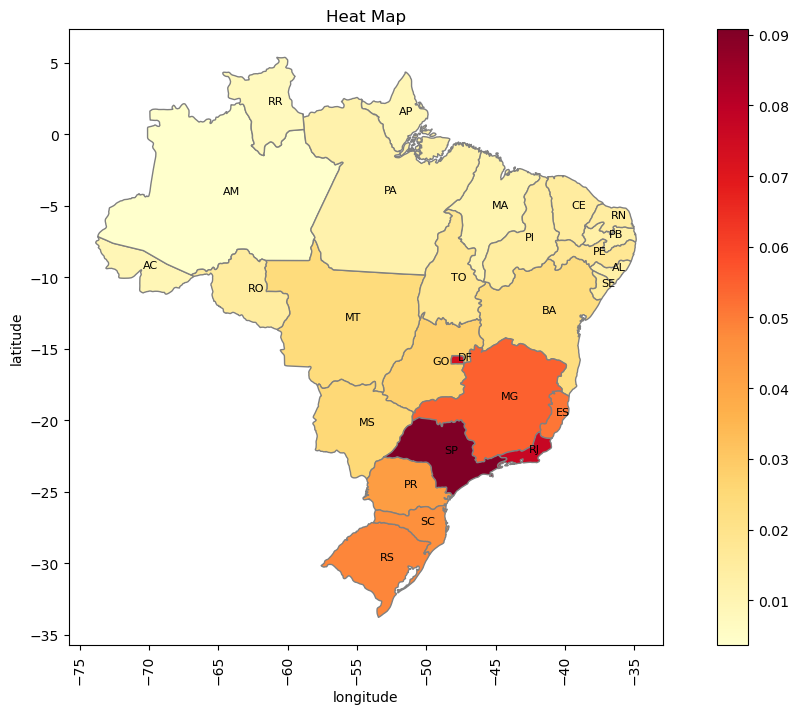

In [12]:
draw_map(gdf, 'density', 'Heat Map', 'UF')

### Finding
We got our highest customer density in South_east region.
Following up is southern region.

We have low customer density in North-east region.
The second most pouplated region is North-east region. 


So, we should focus expanding on north-east region.

Most of our sellers, and infra has been focuesed on South_east region. 
So, it's effective to consider expanding to North-east region.

## Sales/Order